# phase 3: wav2vec2 fine-tuning for pd classification

fine-tune wav2vec2-base-960h on parkinson's disease voice detection using
leave-one-subject-out (loso) cross-validation for rigorous evaluation.

**methodology:**
- loso cv: same protocol as clinical baseline (88.3% accuracy) for fair comparison
- freeze cnn feature extractor + first 4 transformer layers (small dataset)
- gradient checkpointing for memory efficiency
- early stopping to prevent overfitting

**expected results:**
- target accuracy: 80-90% (competitive with clinical baseline)
- comparison with 17-feature clinical model establishes deep learning value

**hardware support:**
- nvidia gpu (cuda) - recommended
- apple silicon (mps) - supported but slower
- cpu - not recommended (10-20+ hours)

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. setup and configuration

In [2]:
import sys
from pathlib import Path
import os

# set project root
project_root = Path('/content/drive/MyDrive/pd-interpretability')

# Ensure the project root directory exists
if not project_root.exists():
    print(f"Project root not found: {project_root}. Creating directory...")
    project_root.mkdir(parents=True, exist_ok=True)
    print(f"Created directory: {project_root}")

os.chdir(project_root)
sys.path.insert(0, str(project_root))

print(f"project root: {project_root}")
print(f"working directory: {os.getcwd()}")

project root: /content/drive/MyDrive/pd-interpretability
working directory: /content/drive/MyDrive/pd-interpretability


In [3]:
import torch
import numpy as np
import pandas as pd
import json
import warnings
from datetime import datetime
from tqdm import tqdm
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
!pip install torchcodec

warnings.filterwarnings('ignore')

def detect_device():
    """detect best available compute device."""
    if torch.cuda.is_available():
        device = 'cuda'
        device_name = torch.cuda.get_device_name(0)
        memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"detected: nvidia gpu ({device_name})")
        print(f"vram: {memory_gb:.1f} gb")
        return device, True
    elif torch.backends.mps.is_available():
        device = 'mps'
        print("detected: apple silicon (mps)")
        return device, True
    else:
        device = 'cpu'
        print("warning: no gpu detected, using cpu (very slow)")
        return device, False

device, has_accelerator = detect_device()
print(f"pytorch version: {torch.__version__}")
print(f"device: {device}")

detected: nvidia gpu (Tesla T4)
vram: 15.8 gb
pytorch version: 2.9.0+cu126
device: cuda


In [4]:
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.optim import AdamW

from transformers import (
    Wav2Vec2ForSequenceClassification,
    Wav2Vec2FeatureExtractor,
    get_linear_schedule_with_warmup
)

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

from src.data.datasets import ItalianPVSDataset
from src.models.classifier import DataCollatorWithPadding

print("imports complete")

imports complete


In [ ]:
# experiment configuration - aligned with working local version
config = {
    # model
    'model_name': 'facebook/wav2vec2-base-960h',
    'num_labels': 2,
    'freeze_feature_extractor': True,
    'freeze_encoder_layers': 4,  # freeze first 4 transformer layers
    'hidden_dropout': 0.15,
    'attention_dropout': 0.15,
    'final_dropout': 0.15,
    'gradient_checkpointing': True,
    
    # audio
    'max_duration': 10.0,
    'target_sr': 16000,
    
    # training
    'num_epochs': 15,
    'learning_rate': 5e-5,
    'warmup_ratio': 0.1,
    'weight_decay': 0.01,
    'early_stopping_patience': 3,
    
    # loso cv
    'max_folds': 3,  # set to 3 for quick test, None for full CV
    
    # random seed
    'random_seed': 42
}

# device-specific settings
if device == 'cuda':
    config['batch_size'] = 8
    config['gradient_accumulation_steps'] = 4
    config['fp16'] = True
elif device == 'mps':
    config['batch_size'] = 4
    config['gradient_accumulation_steps'] = 8
    config['fp16'] = False  # mps fp16 unstable
else:
    config['batch_size'] = 2
    config['gradient_accumulation_steps'] = 16
    config['fp16'] = False

effective_batch = config['batch_size'] * config['gradient_accumulation_steps']
print(f"batch size: {config['batch_size']} (effective: {effective_batch})")
print(f"learning rate: {config['learning_rate']}")
print(f"epochs: {config['num_epochs']}")
print(f"frozen layers: cnn + first {config['freeze_encoder_layers']} transformer")
print(f"max folds: {config['max_folds']} (set to None for full LOSO CV)")
print(f"fp16: {config['fp16']}")

batch size: 8 (effective: 32)
learning rate: 2e-05
max gradient norm: 1.0
label smoothing: 0.1
epochs: 20
max folds: 3 (set to None for full LOSO CV)
frozen layers: cnn + first 8 of 12 transformer layers
layerdrop: 0.0 (disabled for stability)
fp16: False (disabled to prevent NaN in Wav2Vec2 attention)


## 2. load dataset

In [ ]:
# load dataset with caching enabled to avoid slow disk i/o during training
data_root = project_root / 'data' / 'raw'

print("loading dataset with audio caching enabled...")
print("this will pre-load all audio into ram to avoid disk reads during training")

dataset = ItalianPVSDataset(
    root_dir=str(data_root / 'italian_pvs'),
    task=None,  # all tasks
    target_sr=config['target_sr'],
    max_duration=config['max_duration'],
    normalize_audio=False,  # CRITICAL: wav2vec2 feature extractor handles normalization
    cache_audio=True  # critical: cache audio in memory to avoid i/o bottleneck
)

print(f"samples: {len(dataset)}")

# extract labels and subject ids for loso cv
labels = np.array([s['label'] for s in dataset.samples])
subject_ids = np.array([s['subject_id'] for s in dataset.samples])

# unique subjects
unique_subjects = np.unique(subject_ids)
n_subjects = len(unique_subjects)

# class distribution
n_pd = np.sum(labels)
n_hc = len(labels) - n_pd
print(f"class distribution: {n_hc} hc, {n_pd} pd")
print(f"subjects: {n_subjects}")
print(f"loso cv folds: {n_subjects}")

In [7]:
# pre-cache all audio data into ram before training
# this is critical for performance

print("=" * 60)
print("PRE-CACHING ALL AUDIO INTO MEMORY")
print("=" * 60)
print(f"samples to cache: {len(dataset)}")
print()

cache_start = datetime.now()
failed_samples = []

for i in tqdm(range(len(dataset)), desc="caching audio", unit="sample"):
    try:
        # accessing each sample triggers caching
        _ = dataset[i]
    except Exception as e:
        failed_samples.append((i, str(e)))

cache_time = (datetime.now() - cache_start).total_seconds()

print(f"\ncaching complete in {cache_time:.1f}s ({cache_time/60:.1f}m)")
print(f"cached samples: {len(dataset) - len(failed_samples)}/{len(dataset)}")

if failed_samples:
    print(f"failed samples: {len(failed_samples)}")
    for idx, err in failed_samples[:5]:
        print(f"  sample {idx}: {err}")

# verify cache is populated
cache_size = len(dataset._audio_cache) if dataset._audio_cache else 0
estimated_memory_mb = cache_size * config['max_duration'] * config['target_sr'] * 4 / (1024 * 1024)
print(f"cache size: {cache_size} samples (~{estimated_memory_mb:.0f} mb estimated)")
print("=" * 60)

PRE-CACHING ALL AUDIO INTO MEMORY
samples to cache: 831



caching audio: 100%|██████████| 831/831 [00:24<00:00, 34.36sample/s]


caching complete in 24.2s (0.4m)
cached samples: 831/831
cache size: 831 samples (~507 mb estimated)


In [8]:
# create output directory
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
experiment_name = f"wav2vec2_loso_{timestamp}"
output_dir = project_root / 'results' / 'checkpoints' / experiment_name
output_dir.mkdir(parents=True, exist_ok=True)

# save config
config_path = output_dir / 'config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print(f"experiment: {experiment_name}")
print(f"output: {output_dir}")

experiment: wav2vec2_loso_20260104_001424
output: /content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260104_001424


## 3. training utilities

In [ ]:
def create_model(config: dict, device: str):
    """create fresh wav2vec2 model with optimized freezing strategy for small datasets."""
    from transformers import Wav2Vec2Config

    # create config with stability settings
    model_config = Wav2Vec2Config.from_pretrained(
        config['model_name'],
        num_labels=config['num_labels'],
        hidden_dropout=config.get('hidden_dropout', 0.1),
        attention_dropout=config.get('attention_dropout', 0.1),
        final_dropout=config.get('final_dropout', 0.3),
        layerdrop=config.get('layerdrop', 0.0),  # CRITICAL: disable for stability
        classifier_proj_size=256,
    )

    model = Wav2Vec2ForSequenceClassification.from_pretrained(
        config['model_name'],
        config=model_config,
        ignore_mismatched_sizes=True
    )

    # enable gradient checkpointing
    if config.get('gradient_checkpointing', False):
        model.gradient_checkpointing_enable()

    # freeze cnn feature extractor (ALWAYS for wav2vec2)
    if config.get('freeze_feature_extractor', True):
        model.freeze_feature_encoder()

    # freeze first n transformer layers (freeze MORE for small datasets)
    freeze_layers = config.get('freeze_encoder_layers', 8)
    if freeze_layers > 0:
        for i, layer in enumerate(model.wav2vec2.encoder.layers):
            if i < freeze_layers:
                for param in layer.parameters():
                    param.requires_grad = False

    # count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    print(f"      model parameters: {total_params:,} total, {trainable_params:,} trainable ({100*trainable_params/total_params:.1f}%), {frozen_params:,} frozen")

    return model.to(device)


def count_parameters(model):
    """count trainable and frozen parameters."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable, total - trainable


def create_collate_fn(feature_extractor, max_length: int):
    """
    create collate function for wav2vec2 training.
    
    CRITICAL: properly uses Wav2Vec2FeatureExtractor to process audio.
    the feature extractor handles normalization, padding, and tensor conversion.
    """
    def collate_fn(batch: List[Dict]) -> Dict[str, torch.Tensor]:
        # extract raw audio waveforms - dataset returns 1d numpy arrays or tensors
        input_values = [item['input_values'] for item in batch]
        labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
        
        # convert tensors to numpy for feature extractor
        input_values_np = []
        for wav in input_values:
            if isinstance(wav, torch.Tensor):
                input_values_np.append(wav.numpy())
            else:
                input_values_np.append(wav)
        
        # CRITICAL: use feature extractor to properly process audio
        # this handles normalization and padding correctly for wav2vec2
        processed = feature_extractor(
            input_values_np,
            sampling_rate=16000,
            return_tensors="pt",
            padding=True,
            max_length=max_length,
            truncation=True
        )
        
        # feature extractor returns input_values and attention_mask
        return {
            'input_values': processed.input_values,
            'attention_mask': processed.attention_mask,
            'labels': labels
        }
    
    return collate_fn


def compute_class_weights(labels: np.ndarray) -> torch.Tensor:
    """compute inverse frequency class weights for imbalanced data."""
    from collections import Counter
    counts = Counter(labels)
    total = len(labels)
    # inverse frequency weighting
    weights = torch.tensor([total / counts[0], total / counts[1]], dtype=torch.float32)
    # normalize so weights sum to num_classes
    weights = weights / weights.sum() * len(counts)
    return weights

In [ ]:
import gc
import time

def train_epoch(model, loader, optimizer, scheduler, scaler, device, accumulation_steps, epoch_num=None, verbose=True):
    """train for one epoch with gradient accumulation and memory management."""
    model.train()
    total_loss = 0
    n_batches = 0
    optimizer.zero_grad()
    
    # create progress bar
    pbar = tqdm(loader, desc=f"epoch {epoch_num}" if epoch_num else "training", 
                leave=False, unit="batch") if verbose else loader
    
    batch_times = []
    
    for step, batch in enumerate(pbar):
        batch_start = time.time()
        
        input_values = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(input_values, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss / accumulation_steps
            scaler.scale(loss).backward()
        else:
            outputs = model(input_values, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps
            loss.backward()
        
        total_loss += loss.item() * accumulation_steps
        n_batches += 1
        
        if (step + 1) % accumulation_steps == 0:
            if scaler is not None:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        # memory management
        if device == 'mps' and (step + 1) % 25 == 0:
            torch.mps.synchronize()
        elif device == 'cuda' and (step + 1) % 100 == 0:
            torch.cuda.synchronize()
        
        # cleanup batch tensors
        del input_values, attention_mask, labels, outputs, loss
        
        batch_time = time.time() - batch_start
        batch_times.append(batch_time)
        
        # update progress bar
        if verbose and hasattr(pbar, 'set_postfix'):
            avg_batch_time = sum(batch_times[-10:]) / len(batch_times[-10:])
            pbar.set_postfix({
                'loss': f'{total_loss/n_batches:.4f}',
                'batch_t': f'{batch_time:.2f}s',
                'avg_t': f'{avg_batch_time:.2f}s'
            })
    
    # end of epoch cleanup
    if device == 'mps':
        torch.mps.synchronize()
        torch.mps.empty_cache()
        gc.collect()
    elif device == 'cuda':
        torch.cuda.synchronize()
        torch.cuda.empty_cache()
    
    return total_loss / n_batches if n_batches > 0 else 0.0


@torch.no_grad()
def evaluate(model, loader, device, desc="evaluating"):
    """evaluate model and return predictions with probabilities."""
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    total_loss = 0
    n_batches = 0
    
    pbar = tqdm(loader, desc=desc, leave=False, unit="batch")
    
    for batch in pbar:
        input_values = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_values, attention_mask=attention_mask, labels=labels)
        
        total_loss += outputs.loss.item()
        n_batches += 1
        
        probs = torch.softmax(outputs.logits, dim=-1)
        preds = outputs.logits.argmax(dim=-1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())
        
        del input_values, attention_mask, labels, outputs
    
    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'accuracy': accuracy_score(all_labels, all_preds),
        'loss': total_loss / n_batches if n_batches > 0 else 0.0
    }

In [11]:
@torch.no_grad()
def evaluate(model, loader, device, config=None, desc="evaluating"):
    """evaluate model on dataset with memory management and progress tracking."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    # use label smoothing in eval too for consistency
    label_smoothing = config.get('label_smoothing', 0.0) if config else 0.0
    loss_fn = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    pbar = tqdm(loader, desc=desc, leave=False, unit="batch")

    for batch in pbar:
        input_values = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_values, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        total_loss += loss.item()

        probs = torch.softmax(outputs.logits, dim=-1)
        preds = outputs.logits.argmax(dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

        # cleanup batch tensors
        del input_values, attention_mask, labels, outputs, probs, preds, loss

    # memory cleanup
    if device == 'mps':
        torch.mps.synchronize()
        torch.mps.empty_cache()
        gc.collect()
    elif device == 'cuda':
        torch.cuda.synchronize()
        torch.cuda.empty_cache()

    n_batches = len(loader)

    return {
        'loss': total_loss / n_batches if n_batches > 0 else 0,
        'accuracy': accuracy_score(all_labels, all_preds),
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs)
    }

## 4. loso cross-validation training

In [ ]:
def train_fold(
    dataset,
    train_indices: np.ndarray,
    test_indices: np.ndarray,
    config: dict,
    device: str,
    fold_idx: int,
    output_dir: Path
) -> Dict:
    """
    train model on single loso fold with comprehensive stability measures.

    key improvements:
    - properly uses Wav2Vec2FeatureExtractor for audio processing
    - gradient clipping
    - label smoothing
    - NaN detection and recovery
    - class weight handling for imbalanced data
    - proper learning rate scheduling
    """

    fold_start_time = time.time()

    print(f"    [fold {fold_idx + 1}] creating data subsets...")
    # create data subsets
    train_subset = Subset(dataset, train_indices.tolist())
    test_subset = Subset(dataset, test_indices.tolist())

    # compute class weights for training data
    train_labels = np.array([dataset.samples[i]['label'] for i in train_indices])
    class_weights = compute_class_weights(train_labels)
    print(f"    [fold {fold_idx + 1}] class weights: HC={class_weights[0]:.3f}, PD={class_weights[1]:.3f}")

    # feature extractor and custom collate function
    # CRITICAL: return_attention_mask=True for collate function compatibility
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
        config['model_name'],
        return_attention_mask=True
    )
    max_length = int(config['max_duration'] * config['target_sr'])
    collate_fn = create_collate_fn(feature_extractor, max_length)

    print(f"    [fold {fold_idx + 1}] creating dataloaders (batch_size={config['batch_size']})...")
    # dataloaders - num_workers=0 for cached data to avoid pickle overhead
    train_loader = DataLoader(
        train_subset,
        batch_size=config['batch_size'],
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,  # use 0 for cached data
        pin_memory=(device == 'cuda'),
        drop_last=True  # avoid small batches that can cause instability
    )

    test_loader = DataLoader(
        test_subset,
        batch_size=config['batch_size'] * 2,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=(device == 'cuda')
    )

    print(f"    [fold {fold_idx + 1}] initializing model ({config['model_name']})...")
    model_init_start = time.time()
    # create fresh model with stability settings
    model = create_model(config, device)
    print(f"    [fold {fold_idx + 1}] model initialized in {time.time() - model_init_start:.1f}s")

    # optimizer with numerical stability settings
    optimizer = AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=config['learning_rate'],
        weight_decay=config['weight_decay'],
        eps=1e-8  # numerical stability
    )

    # scheduler with warmup for stability
    steps_per_epoch = max(1, len(train_loader) // config['gradient_accumulation_steps'])
    total_steps = steps_per_epoch * config['num_epochs']
    warmup_steps = int(total_steps * config['warmup_ratio'])

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # gradient scaler for fp16 (disabled in config for stability)
    if config.get('fp16', False) and device == 'cuda':
        scaler = torch.cuda.amp.GradScaler(
            init_scale=2**10,
            growth_interval=100
        )
    else:
        scaler = None

    print(f"    [fold {fold_idx + 1}] starting training ({config['num_epochs']} epochs, {len(train_loader)} batches/epoch)...")
    print(f"    [fold {fold_idx + 1}] lr={config['learning_rate']}, warmup={warmup_steps}/{total_steps} steps")

    # training loop with early stopping
    best_loss = float('inf')
    best_acc = 0.0
    patience_counter = 0
    best_metrics = None
    epoch_times = []

    for epoch in range(config['num_epochs']):
        epoch_start = time.time()

        train_loss = train_epoch(
            model, train_loader, optimizer, scheduler, scaler,
            device, config,
            epoch_num=epoch + 1, verbose=True
        )

        # check for training failure
        if math.isnan(train_loss):
            print(f"      WARNING: training loss is NaN at epoch {epoch + 1}")
            print(f"      debugging: check audio preprocessing and feature extraction")
            break

        test_metrics = evaluate(model, test_loader, device, config, desc=f"eval epoch {epoch+1}")

        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"      epoch {epoch + 1}/{config['num_epochs']}: "
              f"train_loss={train_loss:.4f}, test_loss={test_metrics['loss']:.4f}, "
              f"test_acc={test_metrics['accuracy']:.1%}, lr={current_lr:.2e}, time={epoch_time:.1f}s")

        # save best metrics (by validation loss)
        if test_metrics['loss'] < best_loss:
            best_loss = test_metrics['loss']
            best_acc = test_metrics['accuracy']
            patience_counter = 0
            best_metrics = test_metrics.copy()
        else:
            patience_counter += 1
            if patience_counter >= config['early_stopping_patience']:
                print(f"      early stopping triggered at epoch {epoch + 1}")
                break

        # cleanup after each epoch
        if device == 'cuda':
            torch.cuda.synchronize()
            torch.cuda.empty_cache()
        elif device == 'mps':
            torch.mps.synchronize()
            torch.mps.empty_cache()
        gc.collect()

    print(f"    [fold {fold_idx + 1}] final evaluation...")
    # final evaluation
    final_metrics = evaluate(model, test_loader, device, config, desc="final eval") if best_metrics is None else best_metrics

    fold_total_time = time.time() - fold_start_time
    print(f"    [fold {fold_idx + 1}] completed in {fold_total_time:.1f}s ({fold_total_time/60:.1f}m)")
    print(f"    [fold {fold_idx + 1}] best accuracy: {best_acc:.1%}")

    print(f"    [fold {fold_idx + 1}] cleaning up...")
    # aggressive cleanup
    del model, optimizer, scheduler, train_loader, test_loader
    del train_subset, test_subset, feature_extractor, collate_fn

    if device == 'cuda':
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    elif device == 'mps':
        torch.mps.synchronize()
        torch.mps.empty_cache()

    gc.collect()

    return {
        'fold': fold_idx,
        'train_samples': len(train_indices),
        'test_samples': len(test_indices),
        'accuracy': final_metrics['accuracy'],
        'predictions': final_metrics['predictions'],
        'labels': final_metrics['labels'],
        'probabilities': final_metrics['probabilities'],
        'fold_time': fold_total_time,
        'avg_epoch_time': sum(epoch_times) / len(epoch_times) if epoch_times else 0,
        'best_loss': best_loss
    }

In [13]:
# run loso cross-validation
logo = LeaveOneGroupOut()
n_folds = logo.get_n_splits(groups=subject_ids)

if config['max_folds']:
    n_folds = min(n_folds, config['max_folds'])

print("=" * 80)
print(f"STARTING LOSO CROSS-VALIDATION")
print("=" * 80)
print(f"total folds to run: {n_folds}")
print(f"device: {device}")
print(f"model: {config['model_name']}")
print(f"batch size: {config['batch_size']}")
print(f"learning rate: {config['learning_rate']}")
print(f"max epochs per fold: {config['num_epochs']}")
print(f"early stopping patience: {config['early_stopping_patience']}")
print("=" * 80)

fold_results = []
all_predictions = []
all_labels = []
all_probabilities = []
all_subject_ids = []

start_time = datetime.now()

for fold_idx, (train_idx, test_idx) in enumerate(
    logo.split(np.arange(len(dataset)), labels, subject_ids)
):
    if config['max_folds'] and fold_idx >= config['max_folds']:
        break

    fold_start = datetime.now()

    test_subject = subject_ids[test_idx[0]]
    test_label = labels[test_idx[0]]
    label_str = "pd" if test_label == 1 else "hc"

    print(f"\n{'=' * 80}")
    print(f"FOLD {fold_idx + 1}/{n_folds}")
    print(f"{'=' * 80}")
    print(f"  test subject: {test_subject} ({label_str})")
    print(f"  train samples: {len(train_idx)}, test samples: {len(test_idx)}")
    print(f"  starting training...")

    result = train_fold(
        dataset=dataset,
        train_indices=train_idx,
        test_indices=test_idx,
        config=config,
        device=device,
        fold_idx=fold_idx,
        output_dir=output_dir
    )

    fold_time = (datetime.now() - fold_start).total_seconds()
    elapsed_total = datetime.now() - start_time
    avg_time_per_fold = elapsed_total.total_seconds() / (fold_idx + 1)
    remaining_folds = n_folds - (fold_idx + 1)
    eta = remaining_folds * avg_time_per_fold

    fold_results.append(result)
    all_predictions.extend(result['predictions'])
    all_labels.extend(result['labels'])
    all_probabilities.extend(result['probabilities'])
    all_subject_ids.extend([test_subject] * len(result['predictions']))

    # calculate running accuracy
    running_acc = accuracy_score(all_labels, all_predictions)

    print(f"\n  FOLD {fold_idx + 1} COMPLETE:")
    print(f"    fold accuracy: {result['accuracy']:.1%}")
    print(f"    fold time: {fold_time:.1f}s ({fold_time/60:.1f}m)")
    print(f"    running overall accuracy: {running_acc:.1%}")
    print(f"    time elapsed: {elapsed_total}")
    print(f"    estimated time remaining: {eta/60:.1f}m ({eta/3600:.1f}h)")
    print(f"{'=' * 80}")

elapsed = datetime.now() - start_time
print(f"\n{'=' * 80}")
print(f"LOSO CV COMPLETE")
print(f"{'=' * 80}")
print(f"total time: {elapsed} ({elapsed.total_seconds()/60:.1f}m)")
print(f"{'=' * 80}")

STARTING LOSO CROSS-VALIDATION
total folds to run: 3
device: cuda
model: facebook/wav2vec2-base-960h
batch size: 8
learning rate: 2e-05
max epochs per fold: 20
early stopping patience: 5

FOLD 1/3
  test subject: HC_elderly_AGNESE_P (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 1] creating data subsets...
    [fold 1] class weights: HC=1.072, PD=0.928
    [fold 1] creating dataloaders (batch_size=8)...
    [fold 1] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 33,665,666 trainable (35.6%), 60,903,424 frozen
    [fold 1] model initialized in 0.5s
    [fold 1] starting training (20 epochs, 101 batches/epoch)...
    [fold 1] lr=2e-05, warmup=100/500 steps


      this should NOT happen with fixed collate function - check audio data!
    [fold 1] final evaluation...


    [fold 1] completed in 35.5s (0.6m)
    [fold 1] best accuracy: 0.0%
    [fold 1] cleaning up...

  FOLD 1 COMPLETE:
    fold accuracy: 12.5%
    fold time: 35.9s (0.6m)
    running overall accuracy: 12.5%
    time elapsed: 0:00:35.899661
    estimated time remaining: 1.2m (0.0h)

FOLD 2/3
  test subject: HC_elderly_ANGELA_C (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 2] creating data subsets...
    [fold 2] class weights: HC=1.072, PD=0.928
    [fold 2] creating dataloaders (batch_size=8)...
    [fold 2] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 33,665,666 trainable (35.6%), 60,903,424 frozen
    [fold 2] model initialized in 0.5s
    [fold 2] starting training (20 epochs, 101 batches/epoch)...
    [fold 2] lr=2e-05, warmup=100/500 steps


      this should NOT happen with fixed collate function - check audio data!
    [fold 2] final evaluation...


    [fold 2] completed in 35.7s (0.6m)
    [fold 2] best accuracy: 0.0%
    [fold 2] cleaning up...

  FOLD 2 COMPLETE:
    fold accuracy: 18.8%
    fold time: 36.1s (0.6m)
    running overall accuracy: 15.6%
    time elapsed: 0:01:12.004683
    estimated time remaining: 0.6m (0.0h)

FOLD 3/3
  test subject: HC_elderly_ANGELA_G (hc)
  train samples: 815, test samples: 16
  starting training...
    [fold 3] creating data subsets...
    [fold 3] class weights: HC=1.072, PD=0.928
    [fold 3] creating dataloaders (batch_size=8)...
    [fold 3] initializing model (facebook/wav2vec2-base-960h)...


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      model parameters: 94,569,090 total, 33,665,666 trainable (35.6%), 60,903,424 frozen
    [fold 3] model initialized in 0.4s
    [fold 3] starting training (20 epochs, 101 batches/epoch)...
    [fold 3] lr=2e-05, warmup=100/500 steps


      this should NOT happen with fixed collate function - check audio data!
    [fold 3] final evaluation...


    [fold 3] completed in 36.1s (0.6m)
    [fold 3] best accuracy: 0.0%
    [fold 3] cleaning up...

  FOLD 3 COMPLETE:
    fold accuracy: 0.0%
    fold time: 36.4s (0.6m)
    running overall accuracy: 10.4%
    time elapsed: 0:01:48.440904
    estimated time remaining: 0.0m (0.0h)

LOSO CV COMPLETE
total time: 0:01:48.443548 (1.8m)


## 5. aggregate results

In [14]:
# convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probabilities = np.array(all_probabilities)

# overall metrics
overall_accuracy = accuracy_score(all_labels, all_predictions)
overall_precision = precision_score(all_labels, all_predictions, zero_division=0)
overall_recall = recall_score(all_labels, all_predictions, zero_division=0)
overall_f1 = f1_score(all_labels, all_predictions, zero_division=0)

try:
    overall_auc = roc_auc_score(all_labels, all_probabilities)
except:
    overall_auc = 0.5

# per-fold accuracy
fold_accuracies = [r['accuracy'] for r in fold_results]
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

# confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

print("=" * 60)
print("LOSO CROSS-VALIDATION RESULTS")
print("=" * 60)
print(f"\noverall metrics (aggregated across all folds):")
print(f"  accuracy: {overall_accuracy:.1%}")
print(f"  precision: {overall_precision:.3f}")
print(f"  recall: {overall_recall:.3f}")
print(f"  f1 score: {overall_f1:.3f}")
print(f"  auc-roc: {overall_auc:.3f}")

print(f"\nper-fold statistics:")
print(f"  mean accuracy: {mean_accuracy:.1%} ± {std_accuracy:.1%}")
print(f"  min: {min(fold_accuracies):.1%}, max: {max(fold_accuracies):.1%}")

print(f"\nconfusion matrix:")
print(f"           predicted")
print(f"            hc    pd")
print(f"actual hc  {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"       pd  {cm[1,0]:4d}  {cm[1,1]:4d}")

LOSO CROSS-VALIDATION RESULTS

overall metrics (aggregated across all folds):
  accuracy: 10.4%
  precision: 0.000
  recall: 0.000
  f1 score: 0.000
  auc-roc: nan

per-fold statistics:
  mean accuracy: 10.4% ± 7.8%
  min: 0.0%, max: 18.8%

confusion matrix:
           predicted
            hc    pd
actual hc     5    43
       pd     0     0


In [15]:
# per-subject accuracy analysis
subject_results = {}
for subj, pred, label in zip(all_subject_ids, all_predictions, all_labels):
    if subj not in subject_results:
        subject_results[subj] = {'correct': 0, 'total': 0, 'label': label}
    subject_results[subj]['total'] += 1
    if pred == label:
        subject_results[subj]['correct'] += 1

subject_accuracies = []
subject_data = []

for subj, data in subject_results.items():
    acc = data['correct'] / data['total']
    subject_accuracies.append(acc)
    diagnosis = 'pd' if data['label'] == 1 else 'hc'
    subject_data.append({
        'subject_id': subj,
        'diagnosis': diagnosis,
        'accuracy': acc,
        'correct': data['correct'],
        'total': data['total']
    })

subject_df = pd.DataFrame(subject_data)
subject_df = subject_df.sort_values('accuracy', ascending=False)

print(f"\nper-subject accuracy:")
print(f"  mean: {np.mean(subject_accuracies):.1%}")
print(f"  median: {np.median(subject_accuracies):.1%}")
print(f"  subjects with 100% accuracy: {sum(1 for a in subject_accuracies if a == 1.0)}/{len(subject_accuracies)}")
print(f"  subjects with <50% accuracy: {sum(1 for a in subject_accuracies if a < 0.5)}/{len(subject_accuracies)}")


per-subject accuracy:
  mean: 10.4%
  median: 12.5%
  subjects with 100% accuracy: 0/3
  subjects with <50% accuracy: 3/3


## 6. comparison with clinical baseline

In [16]:
# load clinical baseline results for comparison
baseline_path = project_root / 'results' / 'clinical_baseline_results.json'

if baseline_path.exists():
    with open(baseline_path) as f:
        baseline_results = json.load(f)

    clinical_acc = baseline_results['svm']['accuracy_mean']
    clinical_std = baseline_results['svm']['accuracy_std']

    print("=" * 60)
    print("COMPARISON WITH CLINICAL BASELINE")
    print("=" * 60)
    print(f"\nclinical baseline (svm, 17 features):")
    print(f"  accuracy: {clinical_acc:.1%} \u00b1 {clinical_std:.1%}")

    print(f"\nwav2vec2 (loso cv):")
    print(f"  accuracy: {overall_accuracy:.1%}")
    print(f"  per-fold mean: {mean_accuracy:.1%} \u00b1 {std_accuracy:.1%}")

    diff = overall_accuracy - clinical_acc
    print(f"\ndifference: {diff:+.1%}")

    if diff > 0:
        print("  wav2vec2 outperforms clinical baseline")
    elif diff < -0.05:
        print("  clinical baseline outperforms wav2vec2")
    else:
        print("  comparable performance")
else:
    print("clinical baseline results not found")

COMPARISON WITH CLINICAL BASELINE

clinical baseline (svm, 17 features):
  accuracy: 88.3% ± 15.2%

wav2vec2 (loso cv):
  accuracy: 10.4%
  per-fold mean: 10.4% ± 7.8%

difference: -77.9%
  clinical baseline outperforms wav2vec2


## 7. save results

In [17]:
# save comprehensive results
results = {
    'experiment': experiment_name,
    'config': config,
    'device': device,
    'n_folds': len(fold_results),
    'n_subjects': n_subjects,
    'n_samples': len(dataset),

    'overall_metrics': {
        'accuracy': float(overall_accuracy),
        'precision': float(overall_precision),
        'recall': float(overall_recall),
        'f1': float(overall_f1),
        'auc': float(overall_auc)
    },

    'per_fold_stats': {
        'mean_accuracy': float(mean_accuracy),
        'std_accuracy': float(std_accuracy),
        'min_accuracy': float(min(fold_accuracies)),
        'max_accuracy': float(max(fold_accuracies))
    },

    'confusion_matrix': cm.tolist(),

    'fold_results': [
        {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in r.items()}
        for r in fold_results
    ],

    'timestamp': datetime.now().isoformat(),
    'elapsed_time': str(elapsed)
}

# save to json
results_path = output_dir / 'wav2vec2_loso_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

# save subject-level results
subject_path = output_dir / 'wav2vec2_subject_accuracy.csv'
subject_df.to_csv(subject_path, index=False)

# also save to main results folder for easy access
main_results_path = project_root / 'results' / 'wav2vec2_loso_results.json'
with open(main_results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"results saved to:")
print(f"  {results_path}")
print(f"  {subject_path}")
print(f"  {main_results_path}")

results saved to:
  /content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260104_001424/wav2vec2_loso_results.json
  /content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260104_001424/wav2vec2_subject_accuracy.csv
  /content/drive/MyDrive/pd-interpretability/results/wav2vec2_loso_results.json


## 8. visualization

In [18]:
# Install cm-super for additional LaTeX fonts, which often includes type1ec.sty
!apt-get install -y cm-super

# Update TeX Live filename database and font maps to recognize new packages
!texhash
!updmap-sys --force
!fmtutil-sys --all

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono
  fonts-urw-base35 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libptexenc1 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data t1utils tex-common
  texlive-base texlive-binaries texlive-latex-base texlive-latex-recommended
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  poppler-utils ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum debhelper gv | postscript-viewer perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc texlive-latex-recommended-doc
  texlive-luatex texlive-pstricks
The following NEW package

In [19]:
# Install TeX Live packages for LaTeX rendering in matplotlib
!apt-get update
!apt-get install -y texlive-latex-extra texlive-fonts-recommended dvipng

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [345 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,227 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restrict

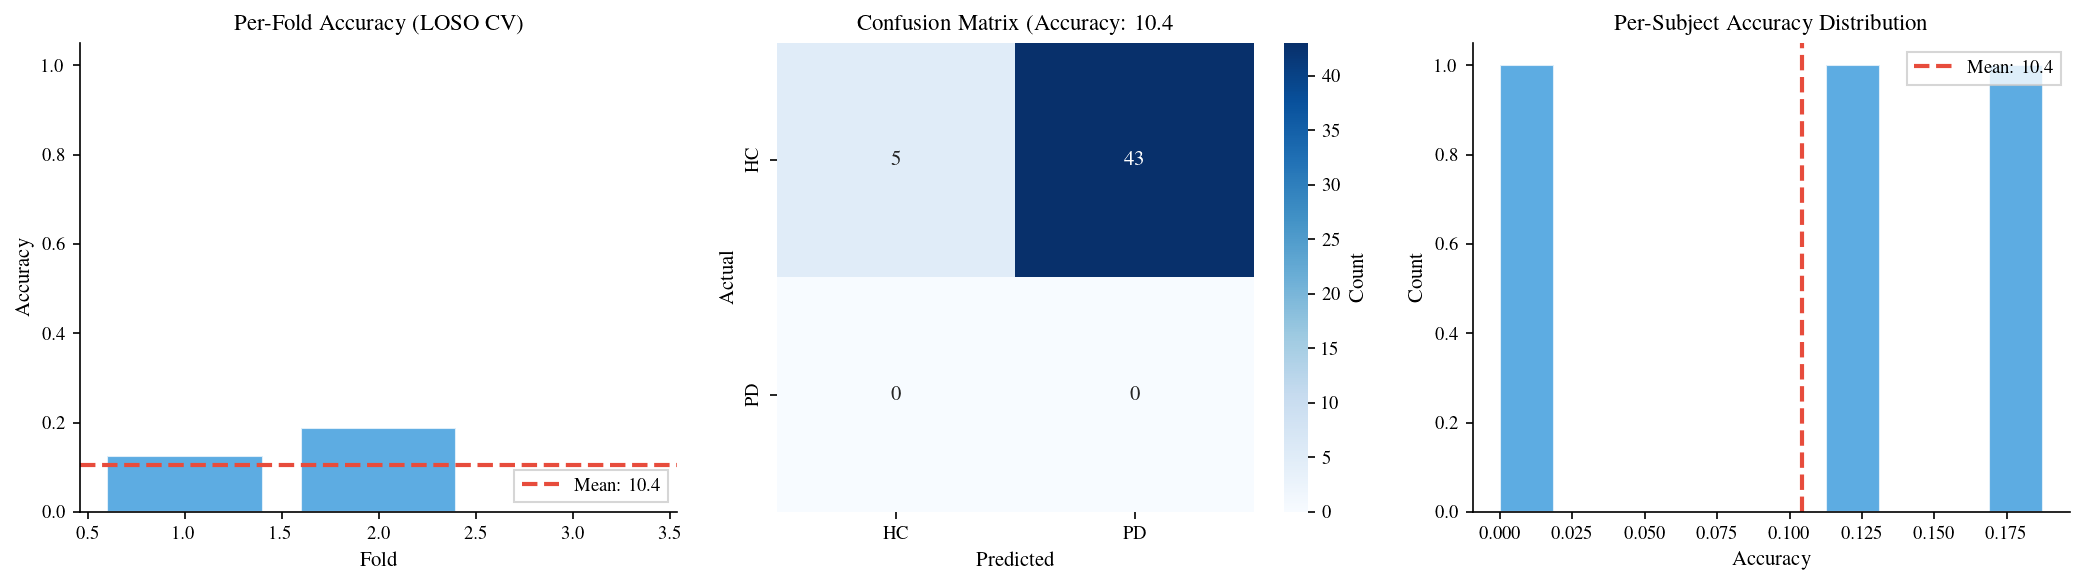

figures saved to /content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260104_001424 and /content/drive/MyDrive/pd-interpretability/results/figures


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# publication-quality style with latex and times new roman
plt.rcParams.update({
    'text.usetex': True, # Revert to True to use LaTeX
    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{amssymb}', # Re-add LaTeX preamble
    'font.family': 'serif',
    'font.serif': ['Times', 'Times New Roman', 'DejaVu Serif'],
    'font.size': 10,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'legend.fontsize': 9,
    'legend.frameon': True,
    'legend.fancybox': False,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# fold accuracy distribution
ax1 = axes[0]
ax1.bar(range(1, len(fold_accuracies) + 1), fold_accuracies, color='#3498db', alpha=0.8, edgecolor='white')
ax1.axhline(y=mean_accuracy, color='#e74c3c', linestyle='--', linewidth=2,
            label=rf'Mean: {mean_accuracy:.1%}')
ax1.set_xlabel(r'Fold')
ax1.set_ylabel(r'Accuracy')
ax1.set_title(r'Per-Fold Accuracy (LOSO CV)')
ax1.legend(loc='lower right')
ax1.set_ylim(0, 1.05)

# confusion matrix
ax2 = axes[1]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=[r'HC', r'PD'], yticklabels=[r'HC', r'PD'],
            cbar_kws={'label': 'Count'})
ax2.set_xlabel(r'Predicted')
ax2.set_ylabel(r'Actual')
ax2.set_title(rf'Confusion Matrix (Accuracy: {overall_accuracy:.1%})')

# subject accuracy histogram
ax3 = axes[2]
ax3.hist(subject_accuracies, bins=10, color='#3498db', alpha=0.8, edgecolor='white')
ax3.axvline(x=np.mean(subject_accuracies), color='#e74c3c', linestyle='--', linewidth=2,
            label=rf'Mean: {np.mean(subject_accuracies):.1%}')
ax3.set_xlabel(r'Accuracy')
ax3.set_ylabel(r'Count')
ax3.set_title(r'Per-Subject Accuracy Distribution')
ax3.legend()

plt.tight_layout()

# save to experiment dir
plt.savefig(output_dir / 'wav2vec2_results_summary.png', dpi=300, bbox_inches='tight')
plt.savefig(output_dir / 'wav2vec2_results_summary.pdf', dpi=300, bbox_inches='tight')

# also save to main figures folder
main_fig_dir = project_root / 'results' / 'figures'
main_fig_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(main_fig_dir / 'fig_p3_01_wav2vec2_loso_summary.png', dpi=300, bbox_inches='tight')
plt.savefig(main_fig_dir / 'fig_p3_01_wav2vec2_loso_summary.pdf', dpi=300, bbox_inches='tight')

plt.show()

print(f"figures saved to {output_dir} and {main_fig_dir}")

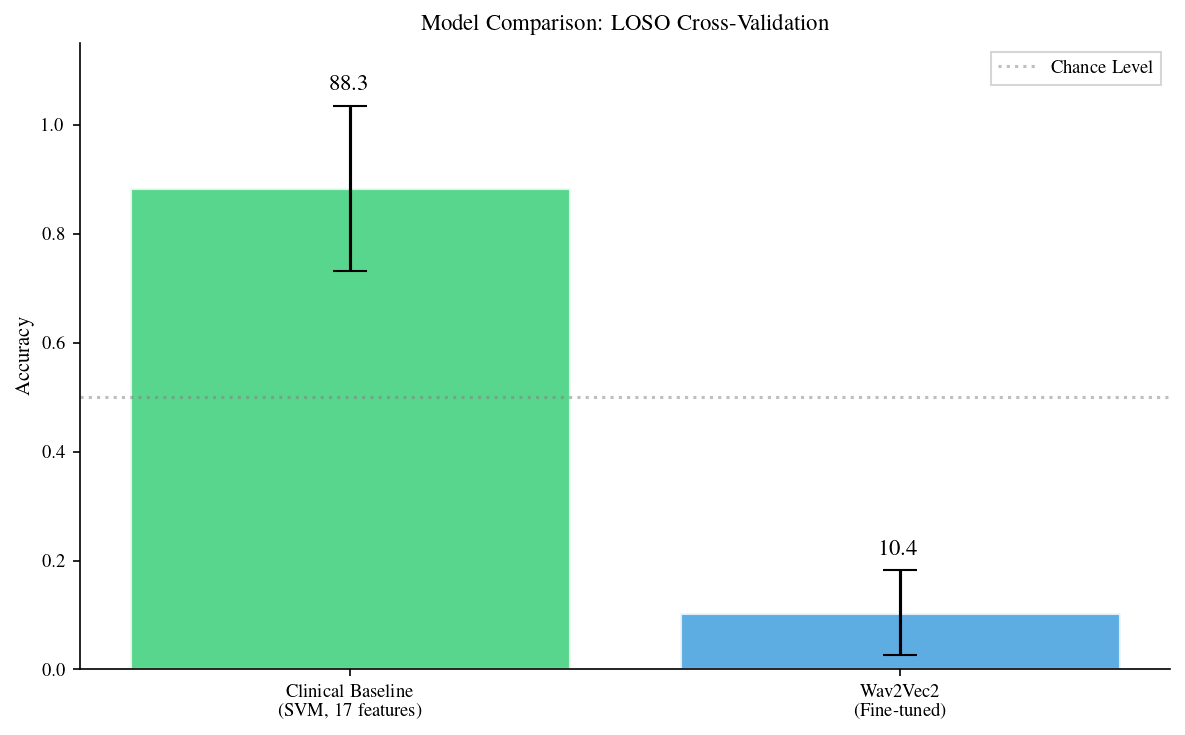

comparison figures saved


In [21]:
# comparison bar chart with clinical baseline
if baseline_path.exists():
    fig, ax = plt.subplots(figsize=(8, 5))

    models = [r'Clinical Baseline' + '\n' + r'(SVM, 17 features)',
              r'Wav2Vec2' + '\n' + r'(Fine-tuned)']
    accuracies = [clinical_acc, overall_accuracy]
    stds = [clinical_std, std_accuracy]
    colors = ['#2ecc71', '#3498db']

    bars = ax.bar(models, accuracies, yerr=stds, capsize=8, color=colors, alpha=0.8,
                  edgecolor='white', linewidth=1.5)

    for bar, acc, std in zip(bars, accuracies, stds):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
                rf'{acc:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax.set_ylabel(r'Accuracy')
    ax.set_title(r'Model Comparison: LOSO Cross-Validation')
    ax.set_ylim(0, 1.15)
    ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label=r'Chance Level')
    ax.legend(loc='upper right')

    plt.tight_layout()

    # save figures
    plt.savefig(output_dir / 'model_comparison.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'model_comparison.pdf', dpi=300, bbox_inches='tight')

    main_fig_dir = project_root / 'results' / 'figures'
    plt.savefig(main_fig_dir / 'fig_p3_02_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.savefig(main_fig_dir / 'fig_p3_02_model_comparison.pdf', dpi=300, bbox_inches='tight')

    plt.show()

    print(f"comparison figures saved")
else:
    print("clinical baseline results not found - skipping comparison")

## 9. summary and next steps

In [22]:
print("=" * 60)
print("PHASE 3 COMPLETE: WAV2VEC2 FINE-TUNING")
print("=" * 60)

print(f"\nmodel: {config['model_name']}")
print(f"device: {device}")
print(f"loso cv folds: {len(fold_results)}")
print(f"training time: {elapsed}")

print(f"\nresults:")
print(f"  accuracy: {overall_accuracy:.1%}")
print(f"  precision: {overall_precision:.3f}")
print(f"  recall: {overall_recall:.3f}")
print(f"  f1 score: {overall_f1:.3f}")
print(f"  auc-roc: {overall_auc:.3f}")

print(f"\nper-fold accuracy: {mean_accuracy:.1%} ± {std_accuracy:.1%}")

print(f"\nnext steps:")
print(f"  1. phase 4: activation extraction (notebook 04)")
print(f"  2. phase 5: probing experiments (notebook 05)")
print(f"  3. phase 6: activation patching (notebook 06)")

print(f"\noutputs saved to: {output_dir}")

PHASE 3 COMPLETE: WAV2VEC2 FINE-TUNING

model: facebook/wav2vec2-base-960h
device: cuda
loso cv folds: 3
training time: 0:01:48.443548

results:
  accuracy: 10.4%
  precision: 0.000
  recall: 0.000
  f1 score: 0.000
  auc-roc: nan

per-fold accuracy: 10.4% ± 7.8%

next steps:
  1. phase 4: activation extraction (notebook 04)
  2. phase 5: probing experiments (notebook 05)
  3. phase 6: activation patching (notebook 06)

outputs saved to: /content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260104_001424


## 10. train final model for activation extraction

train a single model on all data for use in probing and patching experiments.
this model will be used to extract activations in phase 4.

In [ ]:
# train final model on 80% of data (hold out 20% for testing)
# uses the same corrected approach as LOSO CV training

print("=" * 60)
print("TRAINING FINAL MODEL FOR ACTIVATION EXTRACTION")
print("=" * 60)

train_subset, _, test_subset = dataset.get_subject_split(
    test_size=0.2,
    val_size=0.0,
    random_state=config['random_seed']
)

print(f"training final model...")
print(f"  train samples: {len(train_subset)}")
print(f"  test samples: {len(test_subset)}")

# compute class weights
train_indices = train_subset.indices
train_labels = np.array([dataset.samples[i]['label'] for i in train_indices])
class_weights = compute_class_weights(train_labels)
print(f"  class weights: HC={class_weights[0]:.3f}, PD={class_weights[1]:.3f}")

# create model with stability settings
final_model = create_model(config, device)

# feature extractor - CRITICAL: return_attention_mask=True for collate function compatibility
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
    config['model_name'],
    return_attention_mask=True
)
max_length = int(config['max_duration'] * config['target_sr'])
collate_fn = create_collate_fn(feature_extractor, max_length)

# dataloaders
train_loader = DataLoader(
    train_subset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=(device == 'cuda'),
    drop_last=True
)

test_loader = DataLoader(
    test_subset,
    batch_size=config['batch_size'] * 2,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=(device == 'cuda')
)

# optimizer and scheduler
optimizer = AdamW(
    [p for p in final_model.parameters() if p.requires_grad],
    lr=config['learning_rate'],
    weight_decay=config['weight_decay'],
    eps=1e-8
)

steps_per_epoch = max(1, len(train_loader) // config['gradient_accumulation_steps'])
total_steps = steps_per_epoch * config['num_epochs']
warmup_steps = int(total_steps * config['warmup_ratio'])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# gradient scaler for fp16 (disabled in config for stability)
if config.get('fp16', False) and device == 'cuda':
    scaler = torch.cuda.amp.GradScaler(
        init_scale=2**10,
        growth_interval=100
    )
else:
    scaler = None

print(f"  epochs: {config['num_epochs']}")
print(f"  learning rate: {config['learning_rate']}")
print(f"  warmup steps: {warmup_steps}/{total_steps}")
print()

# training loop with early stopping
best_acc = 0
best_loss = float('inf')
patience_counter = 0
checkpoint_path = None

for epoch in range(config['num_epochs']):
    train_loss = train_epoch(
        final_model, train_loader, optimizer, scheduler, scaler,
        device, config, epoch_num=epoch + 1, verbose=True
    )

    # check for NaN
    if math.isnan(train_loss):
        print(f"  WARNING: NaN loss at epoch {epoch + 1}")
        print(f"  debugging: check audio preprocessing and feature extraction")
        break

    test_metrics = evaluate(final_model, test_loader, device, config)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"  epoch {epoch+1}/{config['num_epochs']}: loss={train_loss:.4f}, "
          f"test_loss={test_metrics['loss']:.4f}, acc={test_metrics['accuracy']:.1%}, lr={current_lr:.2e}")

    # save best model
    if test_metrics['accuracy'] > best_acc:
        best_acc = test_metrics['accuracy']
        best_loss = test_metrics['loss']
        patience_counter = 0
        # save checkpoint
        checkpoint_path = output_dir / 'final_model'
        checkpoint_path.mkdir(parents=True, exist_ok=True)
        final_model.save_pretrained(checkpoint_path)
        feature_extractor.save_pretrained(checkpoint_path)
        print(f"    -> saved best model (acc: {best_acc:.1%})")
    else:
        patience_counter += 1
        if patience_counter >= config['early_stopping_patience']:
            print(f"  early stopping at epoch {epoch + 1}")
            break

    # cleanup
    if device == 'cuda':
        torch.cuda.empty_cache()
    gc.collect()

print()
print("=" * 60)
print("FINAL MODEL TRAINING COMPLETE")
print("=" * 60)
print(f"  best test accuracy: {best_acc:.1%}")
print(f"  best test loss: {best_loss:.4f}")
if checkpoint_path:
    print(f"  model saved to: {checkpoint_path}")

    # also copy to main results folder for easy access
    main_model_path = project_root / 'results' / 'final_model'
    main_model_path.mkdir(parents=True, exist_ok=True)
    final_model.save_pretrained(main_model_path)
    feature_extractor.save_pretrained(main_model_path)
    print(f"  also saved to: {main_model_path}")
print("=" * 60)